# Лабораторная работа 4. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Эта лабораторная работа про задачу из соревнования

https://contest.yandex.ru/contest/36927/problems/


**(1 балла) Задание 1.** Знакомство с данными.

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- users), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


In [1]:
%load_ext nb_black

import abc
import functools
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

<IPython.core.display.Javascript object>

In [2]:
class DataReader:
    def read(
        self,
        path_to_csv_files="data/*.csv",
        columns_with_space_separated_ints=("rubrics_id", "features_id", "aspects"),
    ):
        data = {}
        for csv_filename in glob.glob(path_to_csv_files):
            basename, extension = os.path.splitext(os.path.basename(csv_filename))
            data[basename] = pd.read_csv(
                csv_filename,
                converters={
                    c: self.read_ints for c in columns_with_space_separated_ints
                },
            )
        return data

    @staticmethod
    def read_ints(line):
        return list(map(int, line.split()))

<IPython.core.display.Javascript object>

In [3]:
data = DataReader().read()

<IPython.core.display.Javascript object>

In [4]:
DEBUG = True

<IPython.core.display.Javascript object>

In [5]:
if DEBUG:
    data["reviews"] = data["reviews"][: len(data["reviews"]) // 100]
    reviews_user_ids = data["reviews"].user_id
    data["users"] = (
        data["users"].query("user_id in @reviews_user_ids").reset_index(drop=True)
    )
    data["test_users"] = data["test_users"].query("user_id in @reviews_user_ids")
    reviews_org_ids = data["reviews"].org_id
    data["organisations"] = (
        data["organisations"].query("org_id in @reviews_org_ids").reset_index(drop=True)
    )

<IPython.core.display.Javascript object>

* Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.

In [6]:
def describe_review_counts(
    df,
    reviews,
    axis,
    title,
    quantiles=(0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999, 0.9999, 1),
    quantiles_to_plot=(0.5, 0.99, 0.999, 0.9999),
    plt_kwargs=None,
    cmap="hsv",
):
    reviews_count = reviews.groupby(df.index.name).size().reindex(df.index)
    reviews_count.plot(ax=axis, title=title, **(plt_kwargs or {}))
    axis.set_xlabel(plt_kwargs.get("xlabel"))
    axis.set_ylabel(plt_kwargs.get("ylabel"))

    for i, q in enumerate(quantiles_to_plot, start=1):
        quantile = reviews_count.quantile(q=q)
        axis.axvline(quantile, ls="--", c=plt.get_cmap(name=cmap)(q))
        axis.text(quantile, axis.get_ylim()[1] / 2**i, f"{100*q}%", ha="left")

    return reviews_count.agg(
        {
            "mean": pd.Series.mean,
            "std": pd.Series.std,
            **{
                f"{100*q}%": functools.partial(pd.Series.quantile, q=q)
                for q in quantiles
            },
        }
    )


def show_review_counts(data):
    users = data["users"].set_index("user_id")
    organisations = data["organisations"].set_index("org_id")
    reviews = data["reviews"]
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    plt_kwargs = dict(
        kind="hist",
        log=True,
        histtype="stepfilled",
        bins=100,
        edgecolor="black",
        facecolor="gray",
        alpha=0.5,
        xlabel="Reviews count",
        ylabel="Frequency (log scale)",
    )
    return pd.DataFrame(
        {
            title: describe_review_counts(
                df,
                reviews,
                axis,
                title=title,
                plt_kwargs=plt_kwargs,
            )
            for df, axis, title in zip(
                [users, organisations],
                axes,
                ["Users reviews written", "Organisations reviews received"],
            )
        }
    ).T

<IPython.core.display.Javascript object>

,mean,std,0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,99.9%,99.99%,100%
Users reviews written,1.035065,0.206420,1.0,1.0,1.0,1.0,1.0,1.0,2.00,3.000,4.0104,8.0
Organisations reviews received,140.941980,945.568558,1.0,3.0,22.0,99.0,267.4,391.4,894.16,11662.824,15612.1824,16051.0


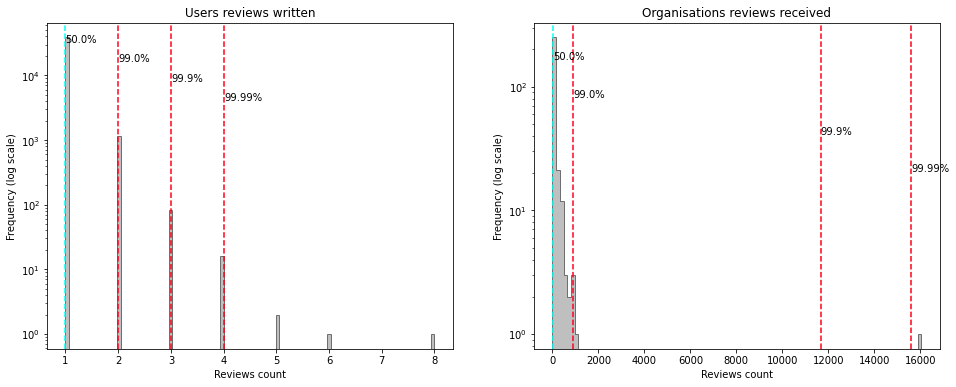

<IPython.core.display.Javascript object>

In [7]:
show_review_counts(data)

* Предложите стратегии фильтрации данных.

Отбросить организации, у которых мало оценок и все они негативные. Это наименее полезные для нас организации, поскольку они одновременно не дают много информации о взаимных интересах пользователей, и не пригодятся для конечных рекомендаций.

Реализация этой стратегии может выглядеть так: мы сортируем организации по значению функции полезности

$$f(\text{organisation}) = (\text{rating count})(1 + \text{rating std})^\alpha (\text{mean rating})^\beta$$

И отсекаем $\gamma$ первых организаций, где $\alpha, \beta$ и $\gamma$ подбираются по нашим предпочтениям.

In [8]:
class Preprocessor:
    @staticmethod
    def filter(reviews, alpha=1, beta=1, gamma=0.9):
        reviews = reviews.dropna(subset=["rating"])
        usefulness = reviews.groupby("org_id").apply(
            functools.partial(
                Preprocessor.calculate_usefulness, alpha=alpha, beta=beta
            ),
        )
        org_ids_to_keep = usefulness.sort_values().index[
            -int(gamma * len(usefulness)) :
        ]
        return reviews.query("org_id in @org_ids_to_keep")

    @staticmethod
    def calculate_usefulness(org_df, alpha, beta):
        usefulness = (
            len(org_df)
            * (1 + org_df["rating"].std(ddof=0)) ** alpha
            * org_df["rating"].mean() ** beta
        )
        return usefulness

    @staticmethod
    def single_train_test_split(reviews, fraction_of_max_possible_test_size):
        ts_grouped_by_user_id = reviews.groupby("user_id")["ts"]
        ranks = ts_grouped_by_user_id.rank(method="first").rename("rank")
        sizes = ts_grouped_by_user_id.size().rename("size")
        test_prob = (
            reviews[["user_id"]]
            .join(ranks)
            .join(sizes, on="user_id")
            .pipe(lambda df: (df["rank"] - 1) / (df["size"] - 1).replace({0: 1}))
            .pipe(lambda s: s / s.sum())
        )
        max_possible_test_size = test_prob.astype(bool).sum()

        np.random.seed(42)

        test_index = np.random.permutation(
            np.random.choice(
                reviews.index,
                size=int(fraction_of_max_possible_test_size * max_possible_test_size),
                replace=False,
                p=test_prob,
            )
        )
        test = reviews.loc[test_index]
        train = reviews.drop(test_index).query("user_id in @test.user_id")
        return train, test

    @staticmethod
    def train_test_split(reviews, test_fractions):
        total_test_fraction = sum(test_fractions)
        train, test = Preprocessor.single_train_test_split(reviews, total_test_fraction)
        test_sizes = [int(len(test) * i / total_test_fraction) for i in test_fractions]
        test_splits = []
        for begin, end in zip(np.cumsum([0] + test_sizes), np.cumsum(test_sizes)):
            test_splits.append(test.iloc[begin:end])

        return train, test_splits

    def build_ids_map(self, users, organisations):
        # self.user_id_map = users["user_id"].sort_index()
        self.user_id_map = users["user_id"].reset_index(drop=True)
        self.reverse_user_id_map = pd.Series(
            self.user_id_map.index, self.user_id_map.values
        ).sort_index()
        # self.org_id_map = organisations["org_id"].sort_index()
        self.org_id_map = organisations["org_id"].reset_index(drop=True)
        self.reverse_org_id_map = pd.Series(
            self.org_id_map.index, self.org_id_map.values
        ).sort_index()

    def map_ids(self, data):
        self.build_ids_map(data["users"], data["organisations"])
        for key, df in data.items():
            if "user_id" in df:
                df["user_id"] = df["user_id"].map(self.reverse_user_id_map)
                df = df.astype({"user_id": np.int32})
            if "org_id" in df:
                df["org_id"] = df["org_id"].map(self.reverse_org_id_map)
                df = df.astype({"org_id": np.int32})
            data[key] = df
        return data

<IPython.core.display.Javascript object>

* Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics. Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?

Эти таблицы содержат текстовые описания, так что можно взять их эмбединги или обучить латентные векторные представления, либо кластеризовать и взять метки кластеров, и использовать все это в качестве дополнительных признаков.

---

**(1 балла) Задание 2.** Организация валидации.

Как вы помните, обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

Следовательно нам необходимо организовать у себя валидацию схожим образом.
Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времени на 3 группы train validation и holdout.

Как уже говорилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делать не будем, но для конкурса имейте это в виду.


In [9]:
preprocessor = Preprocessor()
data = preprocessor.map_ids(data)
train_reviews, (validation_reviews, holdout_reviews) = preprocessor.train_test_split(
    data["reviews"], test_fractions=[0.25, 0.25]  # [0.01, 0]
)

<IPython.core.display.Javascript object>

**(0.5 балла) Задание 3.** Базовые решения.

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

In [10]:
class RandomRecommender:
    def fit(self, reviews):
        self.org_ids = reviews["org_id"].unique()
        return self

    def recommend(self, user_ids, recommend_size=20):
        recommendations = np.random.choice(
            self.org_ids, size=(len(user_ids), recommend_size)
        )
        return pd.DataFrame(recommendations, user_ids)


class PopularRecommender:
    def __init__(self, users, organisations):
        self.users = users
        self.organisations = organisations

    def fit(self, reviews):
        self.popular_foreign_organisations_for_home_city = {}
        organisations = self.organisations.join(
            reviews.groupby("org_id").size().rename("popularity")
        )

        for city in organisations["city"].unique():
            self.popular_foreign_organisations_for_home_city[city] = (
                organisations.query("city != @city")
                .sort_values("popularity", ascending=False)
                .index.to_numpy()
            )
        return self

    def recommend(self, user_ids, recommend_size=20):
        s = pd.Series(
            {
                city: orgs[:recommend_size]
                for city, orgs in self.popular_foreign_organisations_for_home_city.items()
            }
        )

        recommendations = pd.DataFrame(
            np.stack(s.loc[self.users.loc[user_ids]["city"]].values), user_ids
        )

        return recommendations

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 4.** Метрики качества.

Напомним, что у нас бинарная релевантнотсь на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние паекты):

    * MNAP@20 (как в описании соревнования)
    * HitRate ( = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
    * MRR@20 ( обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
    * Coverage (доля item-ов, учитываемых в рекомендациях)
    * Surprisal(см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

In [11]:
from metrics import Metrics

<IPython.core.display.Javascript object>

In [12]:
import pickle


class Assessor:
    def __init__(self, data, train_reviews, validation_reviews, save=False):
        self.data = data
        self.train_reviews = train_reviews
        self.validation_reviews = validation_reviews
        self.save = save

        self.train_users = train_reviews["user_id"].unique()
        self.validation_users = validation_reviews["user_id"].unique()
        self.train_metrics = Metrics(
            train_reviews.query("rating >= 4")[["user_id", "org_id"]]
        )
        self.val_metrics = Metrics(
            validation_reviews.query("rating >= 4")[["user_id", "org_id"]]
        )
        self.assessments = {}

    def assess_model(self, model, name):
        model.fit(self.train_reviews)

        train_recommendations = model.recommend(self.train_users)
        val_recommendations = model.recommend(self.validation_users)

        train_metrics = self.train_metrics.calculate_metrics(train_recommendations)
        val_metrics = self.val_metrics.calculate_metrics(val_recommendations)

        self.assessments[name] = {
            "train_recommendations": train_recommendations,
            "val_recommendations": val_recommendations,
            "train_metrics": train_metrics.rename(name),
            "val_metrics": val_metrics.rename(name),
        }
        if self.save:
            pickle.dump(self.assessments, open("local/assessments.pickle", "wb"))

    def assess(self, models):
        for name, model in models.items():
            self.assess_model(model, name)

    def load_assessments(self):
        self.assessments = pickle.load(open("local/assessments.pickle", "rb"))

    def show_metrics(self, kind="hist"):
        metrics = []
        for dataset in ["train", "val"]:
            metrics.append(
                pd.concat(
                    [i[f"{dataset}_metrics"] for i in self.assessments.values()],
                    axis="columns",
                )
                .T.add_prefix(f"{dataset}_")
                .T
            )

        metrics = pd.concat(metrics).reindex(
            np.array(list(zip(*[i.index for i in metrics]))).flatten()
        )
        if kind == "hist":
            return self.hist_metrics(metrics)
        elif kind == "table":
            return self.table_metrics(metrics)
        else:
            raise ValueError("Unknown visualization method.")

    @staticmethod
    def hist_metrics(metrics):
        metrics.plot(
            figsize=(16, 6),
            kind="bar",
            log=True,
            title="Model metrics, log scale",
            rot=0,
        )

    @staticmethod
    def table_metrics(metrics):
        return metrics.T.style.background_gradient(cmap="coolwarm", low=0.5, high=0.5)

<IPython.core.display.Javascript object>

In [13]:
assessor = Assessor(data, train_reviews, validation_reviews)

<IPython.core.display.Javascript object>

In [14]:
baseline_models = {
    "random": RandomRecommender(),
    "popular": PopularRecommender(data["users"], data["organisations"]),
}
assessor.assess(baseline_models)

<IPython.core.display.Javascript object>

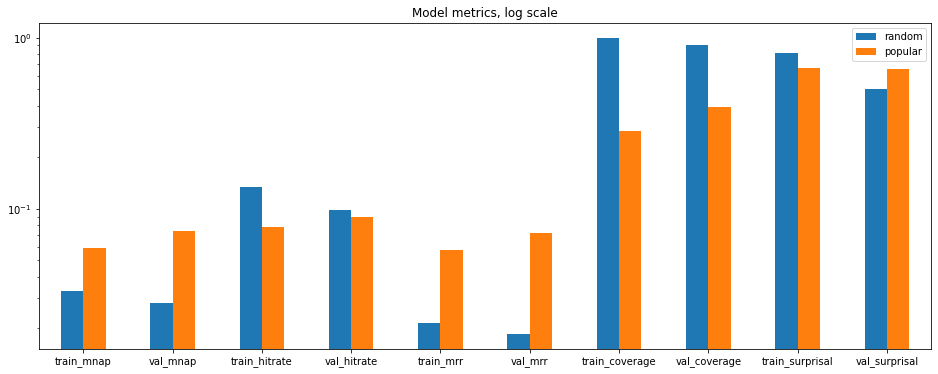

<IPython.core.display.Javascript object>

In [15]:
assessor.show_metrics()

**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выеберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



In [16]:
import implicit

from collections import ChainMap
from scipy.sparse import csr_matrix, coo_matrix
from tqdm.auto import tqdm

try:
    from lightfm.data import Dataset
except ImportError:
    pass


class SparseInterface:
    def __init__(self, data, train_reviews, invalid_org_mark=-1):
        self.data = data
        self.train_reviews = train_reviews
        self.users = self.data["users"]
        self.organisations = self.data["organisations"]
        self.invalid_org_mark = invalid_org_mark

        dataset = Dataset()
        self.fit(dataset)
        self.build_user_features(dataset)
        self.build_item_features(dataset)
        self.build_mapping(dataset)
        self.build_interactions(dataset)

    def build_mapping(self, dataset):
        (
            self.user_id_map,
            self.user_feature_map,
            self.item_id_map,
            self.item_feature_map,
        ) = dataset.mapping()
        self.user_id_map = pd.Series(self.user_id_map)
        item_id_map = pd.Series(self.item_id_map)
        self.item_id_map_reverse = pd.Series(item_id_map.index, item_id_map.values)
        self.item_id_map_reverse[self.invalid_org_mark] = self.invalid_org_mark

    def fit(self, dataset):
        dataset.fit(
            users=self.users["user_id"],
            items=self.organisations["org_id"],
            user_features=self.users["city"].unique(),
            item_features=list(self.organisations["city"].unique())
            + ["average_bill", "rating", "ts"]
            + [f"rubric_{rubric_id}" for rubric_id in self.data["rubrics"]["rubric_id"]]
            + [
                f"feature_{feature_id}"
                for feature_id in self.data["features"]["feature_id"]
            ]
            + [
                f"aspect_{aspect_id}"
                for aspect_id in set(self.data["aspects"]["aspect_id"])
                | set([i for j in train_reviews["aspects"] for i in j])
            ],
        )

    def build_user_features(self, dataset):
        self.user_features = dataset.build_user_features(
            zip(self.users["user_id"].values, self.users[["city"]].values),
            normalize=False,
        )

    @staticmethod
    def normalize(s):
        return (s - s.mean()) / s.std()

    @staticmethod
    def parse_list_of_feature_ids(feature_ids, name):
        try:
            return {f"{name}_{feature_id}": True for feature_id in feature_ids}
        except TypeError:
            return {}

    @staticmethod
    def extract_org_features(org_row):
        org_features = {
            **{org_row["city"]: True},
            **org_row[["average_bill", "rating", "ts"]].dropna().to_dict(),
            **SparseInterface.parse_list_of_feature_ids(
                org_row["rubrics_id"], "rubric"
            ),
            **SparseInterface.parse_list_of_feature_ids(
                org_row["features_id"], "feature"
            ),
            **SparseInterface.parse_list_of_feature_ids(
                org_row["aspects_id"], "aspect"
            ),
        }
        return org_features

    def build_item_features(self, dataset):
        organisations = self.organisations
        organisations["rating"] = self.normalize(organisations["rating"])
        organisations["average_bill"] = self.normalize(organisations["average_bill"])
        organisations["ts"] = self.normalize(
            self.train_reviews.groupby("org_id")["ts"].mean()
        )
        organisations["aspects_id"] = self.train_reviews.groupby("org_id")[
            "aspects"
        ].agg(lambda s: [i for j in s.values for i in j])
        self.item_features = dataset.build_item_features(
            (
                (
                    org_row["org_id"],
                    self.extract_org_features(org_row),
                )
                for org_id, org_row in organisations.iterrows()
            ),
            normalize=False,
        )

    def build_interactions(self, dataset):
        self.interactions, self.interactions_weighted = dataset.build_interactions(
            self.train_reviews[["user_id", "org_id", "rating"]]
            .dropna()
            .astype(np.int32)
            .values
        )

    @staticmethod
    def single_scale_features(features, relative_feature_importance):
        features = features.copy()
        n = features.shape[0]
        features_norm = features[:, n:].sum(axis=1)
        features[:, n:] = csr_matrix(
            features[:, n:].multiply(relative_feature_importance / features_norm)
        )
        return features

    def scale_features(self, relative_feature_importance):
        scaled_user_features = self.single_scale_features(
            self.user_features, relative_feature_importance
        )
        scaled_item_features = self.single_scale_features(
            self.item_features, relative_feature_importance
        )
        return scaled_user_features, scaled_item_features

    def user_ids_to_latent(self, user_ids):
        return self.user_id_map.loc[user_ids]

    def recommended_org_ids_from_latent(self, latent_recommendations):
        recommendations = latent_recommendations.apply(
            lambda s: self.item_id_map_reverse.loc[s].values
        )
        return recommendations

<IPython.core.display.Javascript object>

In [17]:
# import pickle
# import scipy.sparse

# sparse_interface = SparseInterface(data, train_reviews)
# scipy.sparse.save_npz(
#     f"local/train_explicit{'_debug' if DEBUG else ''}.npz",
#     sparse_interface.interactions_weighted,
# )
# val_sparse = SparseInterface(data, pd.concat([train_reviews, validation_reviews]))
# diff = val_sparse.interactions_weighted - sparse_interface.interactions_weighted
# scipy.sparse.save_npz(f"local/val_explicit{'_debug' if DEBUG else ''}.npz", diff)


# pickle.dump(
#     sparse_interface,
#     open(f"local/sparse_interface{'_debug' if DEBUG else ''}.pickle", "wb"),
# )

<IPython.core.display.Javascript object>

In [18]:
import pickle

sparse_interface = pickle.load(
    open(f"local/sparse_interface{'_debug' if DEBUG else ''}.pickle", "rb")
)

/tmp/ipykernel_49164/830034327.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  sparse_interface = pickle.load(
/tmp/ipykernel_49164/830034327.py:3: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is deprecated.
  sparse_interface = pickle.load(


<IPython.core.display.Javascript object>

In [19]:
class SparseRecommender:
    def __init__(self, sparse_interface, model):
        self.model = model
        self.sparse_interface = sparse_interface

    def fit(self, reviews):
        self.interactions = csr_matrix(self.sparse_interface.interactions_weighted)
        self.model.fit(self.interactions)
        return self

    def recommend(self, user_ids, recommend_size=20):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        recommendations, predicted_ratings = self.model.recommend(
            userid=user_ids_mapped,
            user_items=self.interactions[user_ids_mapped],
            N=recommend_size,
        )
        recommendations = pd.DataFrame(recommendations, user_ids)
        return self.sparse_interface.recommended_org_ids_from_latent(recommendations)

<IPython.core.display.Javascript object>

In [20]:
nn_models = {
    "tfidf": SparseRecommender(
        sparse_interface, implicit.nearest_neighbours.TFIDFRecommender()
    ),
    "bm25": SparseRecommender(
        sparse_interface, implicit.nearest_neighbours.BM25Recommender()
    ),
    "cosine": SparseRecommender(
        sparse_interface, implicit.nearest_neighbours.CosineRecommender()
    ),
}

assessor.assess(nn_models)

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

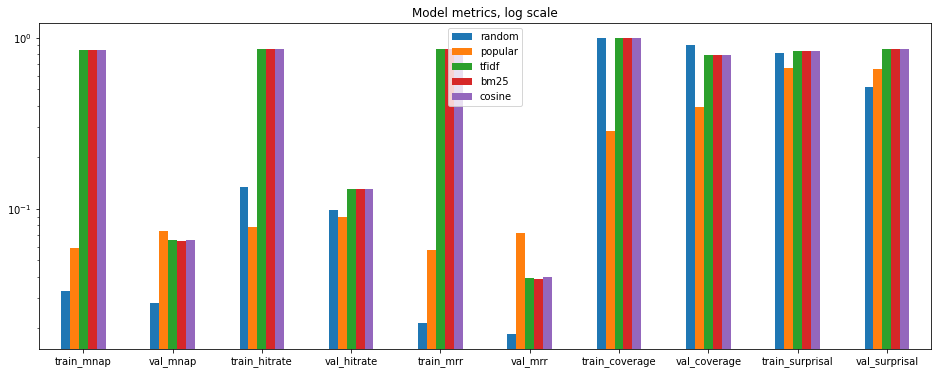

<IPython.core.display.Javascript object>

In [21]:
assessor.show_metrics()

## Методы Matrix factorization

**(0.5 балла) Задание 6.**

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

Получим представление о том, какие варианты значенией ранга разложения следует попробовать:

In [20]:
from sklearn.decomposition import TruncatedSVD


def plot_component_importance(sparse_interface, n_components=100):
    truncated_svd = TruncatedSVD(n_components=n_components)
    truncated_svd.fit(sparse_interface.interactions_weighted)

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(truncated_svd.explained_variance_ratio_)
    plt.xlabel("n components")
    plt.ylabel("explained variance ratio")
    plt.title("Explained variance depending on number of components")

<IPython.core.display.Javascript object>

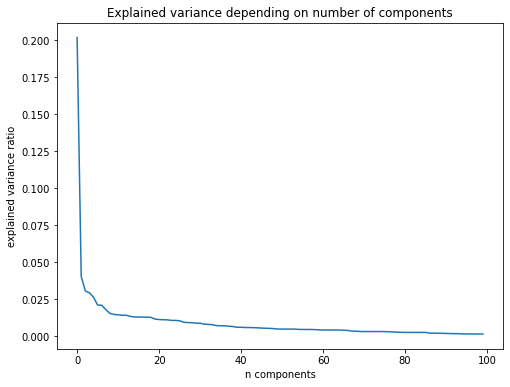

<IPython.core.display.Javascript object>

In [21]:
plot_component_importance(sparse_interface)

In [22]:
import torch


class BatchRecommender(SparseRecommender):
    def recommend(self, user_ids, recommend_size=20, batch_size=1024):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        interactions = csr_matrix(self.sparse_interface.interactions_weighted)[
            user_ids_mapped
        ]
        recommendations = []

        for begin in tqdm(range(0, len(user_ids), batch_size), "Recommending"):
            batch_slice = slice(begin, begin + batch_size)
            batch_interactions = interactions[batch_slice]
            batch_ids = user_ids[batch_slice]
            batch_ids_mapped = user_ids_mapped[batch_slice]

            batch_rec = self.model_recommend(
                batch_ids_mapped.values, batch_interactions
            )

            if batch_rec.shape[1] > recommend_size:
                if not torch.is_tensor(batch_rec):
                    batch_rec = torch.tensor(batch_rec)
                batch_rec = batch_rec.to("cuda")
                values, indices = torch.topk(batch_rec, recommend_size)
                batch_rec = indices[:, :recommend_size].cpu().numpy()
                del values, indices

            batch_rec = pd.DataFrame(batch_rec, batch_ids)
            recommendations.append(batch_rec)

        recommendations = self.sparse_interface.recommended_org_ids_from_latent(
            pd.concat(recommendations)
        )
        return recommendations

    def model_recommend(self, user_ids, interactions):
        return self.model.recommend(user_ids)


class SVDRecommender(BatchRecommender):
    def model_recommend(self, user_ids, interactions):
        embedding = self.model.transform(interactions)
        recommendations = self.model.inverse_transform(embedding)
        return recommendations

<IPython.core.display.Javascript object>

In [25]:
matrix_factorization_models = {
    f"svd_{n_components}": SVDRecommender(
        sparse_interface, TruncatedSVD(n_components=n_components)
    )
    for n_components in np.logspace(1, 2, num=3, dtype=int)
}

assessor.assess(matrix_factorization_models)

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [26]:
assessor.show_metrics(kind="table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.032909,0.027927,0.133627,0.098266,0.021530,0.018505,1.000000,0.906977,0.814839,0.513508
popular,0.059019,0.073702,0.077827,0.089595,0.057450,0.071810,0.284672,0.395349,0.664661,0.654923
tfidf,0.850790,0.065181,0.856094,0.130058,0.852668,0.039467,1.000000,0.790698,0.830364,0.860514
bm25,0.850790,0.064779,0.856094,0.130058,0.852668,0.038986,1.000000,0.790698,0.830364,0.860225
cosine,0.850790,0.065891,0.856094,0.130058,0.852668,0.039869,1.000000,0.790698,0.830364,0.860514
svd_10,0.495708,0.075030,0.660793,0.208092,0.458631,0.047947,0.540146,0.581395,0.714339,0.614379
svd_31,0.650337,0.046344,0.743025,0.156069,0.629986,0.029147,0.664234,0.697674,0.745323,0.584569
svd_100,0.837186,0.012519,0.848752,0.057803,0.833845,0.007223,1.000000,0.837209,0.929336,0.339059


<IPython.core.display.Javascript object>

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

**(1.0 балла) Задание 7.**
Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

In [23]:
from als import ALS, ALS_jit, ALS_biased_jit

<IPython.core.display.Javascript object>

In [24]:
def explain_recommendations(my_als_model, user_id):
    recommendations, explanations = my_als_model.recommend(
        user_ids=[user_id], explain=True
    )
    explanations = explanations[user_id]
    if explanations is None:
        raise ValueError("No personal recommendations generated, probably a cold user.")

    df = pd.concat(
        [explanations["ratings"], explanations["similarity"]], axis="columns"
    )
    df = pd.concat([df.T, explanations["confidence"]], axis="columns").T.rename_axis(
        index="recommended items", columns="liked items"
    )

    style = df.style

    style.set_caption(
        f"Recommended items for user {user_id} based on personal similarity measure "
        "between items and estimated confidence in these similarities."
    ).set_table_styles(
        [
            dict(
                selector="caption",
                props=[
                    ("text-align", "center"),
                    ("font-size", "125%"),
                    ("color", "black"),
                ],
            )
        ]
    )

    common_gradient_kwargs = dict(low=0.5, high=0.5)
    style = style.background_gradient(
        subset=(df.index[-1], df.columns[:-1]),
        axis="columns",
        **common_gradient_kwargs,
        cmap="YlOrRd",
    )
    style = style.background_gradient(
        subset=(df.index[:-1], df.columns[:-1]),
        **common_gradient_kwargs,
        cmap="coolwarm",
    )
    style = style.background_gradient(
        subset=(df.index[:-1], df.columns[-1]), **common_gradient_kwargs, cmap="YlOrRd"
    )

    return style

<IPython.core.display.Javascript object>

In [29]:
my_als_models = {
    "my_als": BatchRecommender(sparse_interface, ALS_jit()),
    "my_biased_als": BatchRecommender(sparse_interface, ALS_biased_jit()),
}
assessor.assess(my_als_models)

Alternating:   0%|          | 0/10 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Alternating:   0%|          | 0/10 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [30]:
assessor.show_metrics("table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.032909,0.027927,0.133627,0.098266,0.021530,0.018505,1.000000,0.906977,0.814839,0.513508
popular,0.059019,0.073702,0.077827,0.089595,0.057450,0.071810,0.284672,0.395349,0.664661,0.654923
tfidf,0.850790,0.065181,0.856094,0.130058,0.852668,0.039467,1.000000,0.790698,0.830364,0.860514
bm25,0.850790,0.064779,0.856094,0.130058,0.852668,0.038986,1.000000,0.790698,0.830364,0.860225
cosine,0.850790,0.065891,0.856094,0.130058,0.852668,0.039869,1.000000,0.790698,0.830364,0.860514
svd_10,0.495708,0.075030,0.660793,0.208092,0.458631,0.047947,0.540146,0.581395,0.714339,0.614379
svd_31,0.650337,0.046344,0.743025,0.156069,0.629986,0.029147,0.664234,0.697674,0.745323,0.584569
svd_100,0.837186,0.012519,0.848752,0.057803,0.833845,0.007223,1.000000,0.837209,0.929336,0.339059
my_als,0.820055,0.095288,0.856094,0.210983,0.795203,0.060580,1.000000,0.906977,0.745391,0.571474
my_biased_als,0.841966,0.051868,0.856094,0.132948,0.832354,0.029238,1.000000,0.906977,0.797048,0.486327


<IPython.core.display.Javascript object>

In [31]:
explain_recommendations(
    my_als_models["my_als"].model,
    user_id=sparse_interface.user_ids_to_latent(
        validation_reviews["user_id"].unique()[0]
    ),
)

/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


liked items,predicted relevance,158
recommended items,,
158,0.946840,0.004718
182,0.680168,0.003541
221,0.630108,0.003073
114,0.524252,0.002684
96,0.486934,0.002394
91,0.449566,0.002318
12,0.448809,0.002260
191,0.447261,0.002213
280,0.442225,0.002233


<IPython.core.display.Javascript object>

In [25]:
import wandb

from pmf import LitProbabilityMatrixFactorization, PMFConfigDispenser, PMFTrainer


class LitRecommender:
    def __init__(
        self,
        LitModule,
        checkpoint=None,
        *,
        ConfigDispenser=None,
        Trainer=None,
        config=None,
        gpu=1,
    ):
        if checkpoint:
            self.model = LitModule.load_from_checkpoint(checkpoint)
        else:

            def main(config):
                trainer = Trainer(config)
                self.model = trainer.lightning_module
                trainer.main()
                wandb.finish()

            config_dispenser = ConfigDispenser(main)
            config_dispenser.launch(config=config, gpu=gpu, debug=DEBUG)

    def fit(self, explicit_feedback, implicit_feedback=None):
        pass

    def recommend(self, user_ids):
        return self.model(user_ids=torch.tensor(user_ids))

<IPython.core.display.Javascript object>

In [61]:
pmf_models = {
    #     "pmf_mse_loss": BatchRecommender(
    #         sparse_interface,
    #         LitRecommender(
    #             LitProbabilityMatrixFactorization,
    #             ConfigDispenser=PMFConfigDispenser,
    #             Trainer=PMFTrainer,
    #             config="configs/pmf_run_mse_loss.yaml",
    #         ),
    #     ),
    #         "pmf_ranking_loss": BatchRecommender(
    #             sparse_interface,
    #             LitRecommender(
    #                 LitProbabilityMatrixFactorization,
    #                 ConfigDispenser=PMFConfigDispenser,
    #                 Trainer=PMFTrainer,
    #                 config="configs/pmf_run_ranking_loss.yaml",
    #             ),
    #         ),
    "cpmf_ranking_loss": BatchRecommender(
        sparse_interface,
        LitRecommender(
            LitProbabilityMatrixFactorization,
            ConfigDispenser=PMFConfigDispenser,
            Trainer=PMFTrainer,
            config="configs/cpmf_run_ranking_loss.yaml",
        ),
    ),
}
assessor.assess(pmf_models)

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇██▂
train_loss,▅▅▄▅▄▄▄▄▄▄▄▄▄▄▄█▇█▇▆▆▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇██▂
val_loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▅██▇▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅
epoch,8
train_loss,0.06196
trainer/global_step,8
val_loss,0.4767


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]



  | Name  | Type                                      | Params
--------------------------------------------------------------------
0 | model | ConstrainedProbabilityMatrixFactorization | 445 K 
--------------------------------------------------------------------
445 K     Trainable params
0         Non-trainable params
445 K     Total params
1.780     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [26]:
assessor.show_metrics(kind="table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.032909,0.027927,0.133627,0.098266,0.021530,0.018505,1.000000,0.906977,0.814839,0.501585
popular,0.059019,0.073702,0.077827,0.089595,0.057450,0.071810,0.284672,0.395349,0.664661,0.654923


<IPython.core.display.Javascript object>

In [30]:
from slim import LitSLIM, RecommendingConfigDispenser, SLIMTrainer

class LitSLIMRecommender(LitRecommender):
    def recommend(self, user_ids):
        return super().recommend(user_ids).to_dense()
    
slim_models = {
    "slim": BatchRecommender(
        sparse_interface,
        LitSLIMRecommender(
            LitSLIM,
            ConfigDispenser=RecommendingConfigDispenser,
            Trainer=SLIMTrainer,
            config="configs/slim_run.yaml",
        ),
    ),
}
assessor.assess(slim_models)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

density,█▁▃
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
train_loss,█▇▆▅▅▅▄▄▄▄▄▄▄▆▅▄▄▃▃▃▂▂▂▂▂▂▇▅▄▃▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▆▅▄▄▃▃▃▃▃▃▃▆▆▄▄▃▃▂▂▂▂▂▂▂▇▆▄▄▃▂▂▁▁▁▁▁▁▁
density,0.00495
epoch,2
train_loss,0.02704
trainer/global_step,639
val_loss,0.01952


Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [31]:
assessor.show_metrics(kind="table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.032909,0.027927,0.133627,0.098266,0.021530,0.018505,1.000000,0.906977,0.814839,0.501585
popular,0.059019,0.073702,0.077827,0.089595,0.057450,0.071810,0.284672,0.395349,0.664661,0.654923
slim,0.090826,0.092960,0.140969,0.138728,0.081174,0.078261,0.751825,0.709302,0.425978,0.289910


<IPython.core.display.Javascript object>

Bayesian PMF, MCMC sampling:

Sample features step:

$$
p\left(U_i \mid R, V, \Theta_U, \alpha\right)=
\cfrac{p\left(R \mid U_i, V, \Theta_U, \alpha\right)p\left(U_i \mid V, \Theta_U, \alpha\right)}
{p\left(R \mid V, \Theta_U, \alpha\right)}\sim
$$

$$
\sim p\left(R \mid U_i, V, \Theta_U, \alpha\right)p\left(U_i \mid V, \Theta_U, \alpha\right) \sim \\
\sim \prod_{j=1}^M\left[\mathcal{N}\left(R_{i j} \mid U_i^T V_j, \alpha^{-1}\right)\right]^{I_{i j}} \mathcal{N}\left(U_i \mid \mu_U, \left[\Lambda_U \right]^{-1}\right)\sim\\
\sim \exp\left\{
\left(\sum_{j=1}^M-I_{i j}\alpha\frac{(R_{i j} - U_i^T V_j)^2} {2} \right) -
\frac{1}{2}(U_i - \mu_U)^T\Lambda_U(U_i - \mu_U)
\right\}
$$

Let's show that this is a multivariate normal distribution. Its variance is:

$$
U_i^T\text{Variance }^{-1}U_i=
\left(\sum_{j=1}^M\alpha I_{i j}(R_{ij} - U_i^T V_j)^2 \right) + (U_i - \mu_U)^T\Lambda_U(U_i - \mu_U) +\cdots=\\
=\left(\sum_{j=1}^M \alpha I_{i j}(U_i^T V_j)^2 \right) + U_i^T\Lambda_U U_i=
\left(\sum_{j=1}^M\alpha I_{i j}(U_i^T V_j)(U_i^T V_j)^T \right) + U_i^T\Lambda_U U_i=\\
=\left(\sum_{j=1}^M\alpha I_{i j}U_i^T V_j V_j^T U_i \right) + U_i^T\Lambda_U U_i=
U_i^T\left(\sum_{j=1}^M\alpha I_{i j}V_j V_j^T  + \Lambda_U \right)U_i
$$

$$
\text{Variance }^{-1} =\alpha\sum_{j=1}^M I_{i j}V_j V_j^T + \Lambda_U 
$$


And the mean:

$$
-\frac{1}{2}(U_i - \text{Mean})^T\text{Variance}^{-1}(U_i - \text{Mean})=
\frac{1}{2} \text{Mean}^T\text{Variance}^{-1}U_i +\frac{1}{2}
U_i^T\text{Variance}^{-1}\text{Mean} + \cdots=\\
=U_i^T\text{Variance}^{-1}\text{Mean}+ \cdots
$$

$$
U_i^T\text{Variance}^{-1}\text{Mean} =
\left(\sum_{j=1}^M-I_{i j}\alpha\frac{-2R_{i j} U_i^T V_j} {2} \right) +
U_i^T\Lambda_U\mu_U=\\
=\alpha\sum_{j=1}^M I_{i j}R_{i j} U_i^T V_j + U_i^T\Lambda_U\mu_U=\\
=U_i^T\left(\alpha\sum_{j=1}^M I_{i j}R_{i j} V_j + \Lambda_U\mu_U \right)
$$

$$
\text{Mean} = \text{Variance} \left(\alpha\sum_{j=1}^M I_{i j}R_{i j} V_j + \Lambda_U\mu_U \right)
$$

For hyperparameter estimation, see [Normal-Wishart distribution](https://en.wikipedia.org/wiki/Normal-Wishart_distribution)

In [32]:
from bayesian_pmf import BayesianPMF


class BayesianPMFExtendingALS(BayesianPMF):
    def __init__(
        self,
        explicit,
        burn_in_steps,
        keeper_steps,
        predictive_explicit_precision,
        features_hyper_precision_coefficient,
        fitted_als,
    ):
        self.fitted_als = fitted_als
        super().__init__(
            explicit=explicit,
            n_feature_dimensions=fitted_als.user_factors.shape[1],
            burn_in_steps=burn_in_steps,
            keeper_steps=keeper_steps,
            predictive_explicit_precision=predictive_explicit_precision,
            features_hyper_precision_coefficient=features_hyper_precision_coefficient,
        )

    def init_user_features(self):
        return self.fitted_als.user_factors

    def init_item_features(self):
        return self.fitted_als.item_factors

<IPython.core.display.Javascript object>

In [33]:
class BPMFRecommender:
    def __init__(self, model):
        self.model = model

    def fit(self, explicit_feedback, implicit_feedback=None):
        self.model.fit()

    def recommend(self, user_ids):
        return self.model.recommend(user_ids)

<IPython.core.display.Javascript object>

In [34]:
bpmf_models = {
    "bpmf": BatchRecommender(
        sparse_interface,
        BPMFRecommender(
            BayesianPMF(
                explicit=sparse_interface.interactions_weighted.tocsr(),
                n_feature_dimensions=10,
                burn_in_steps=100,
                keeper_steps=10,
                predictive_explicit_precision=2,
                features_hyper_precision_coefficient=2,
            )
        ),
    ),
    #     "ebpmf": BatchRecommender(
    #         sparse_interface,
    #         BPMFRecommender(
    #             BayesianPMFExtendingALS(
    #                 fitted_als=my_als_models["my_als"].model,
    #                 explicit=sparse_interface.interactions_weighted.tocsr(),
    #                 burn_in_steps=100,
    #                 keeper_steps=10,
    #                 predictive_explicit_precision=2,
    #                 features_hyper_precision_coefficient=2,
    #             )
    #         ),
    #     ),
}
assessor.assess(bpmf_models)

Sampling:   0%|          | 0/110 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

Recommending:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [35]:
assessor.show_metrics(kind="table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.032909,0.027927,0.133627,0.098266,0.021530,0.018505,1.000000,0.906977,0.814839,0.501585
popular,0.059019,0.073702,0.077827,0.089595,0.057450,0.071810,0.284672,0.395349,0.664661,0.654923
slim,0.090826,0.092960,0.140969,0.138728,0.081174,0.078261,0.751825,0.709302,0.425978,0.289910
bpmf,0.018275,0.014932,0.066079,0.054913,0.011902,0.009530,0.985401,0.988372,0.413791,0.224321


<IPython.core.display.Javascript object>

In [38]:
import einops


def plot_bayesian_pmf_distributions(means, precision):
    means = torch.from_numpy(means)
    n_steps, n_users, n_items = means.shape
    fig, axis = plt.subplots(n_users, n_items, figsize=(4 * n_items, 3.25 * n_users))
    fig.suptitle("Distributions of rating values for user-item pairs", fontsize=16)

    for user_id, row_axes in enumerate(axis):
        for item_id, axis in enumerate(row_axes):
            axis.set_title(f"Rating of item {item_id} for user {user_id}")
            user_item_means = means[:, user_id, item_id]
            linspace = torch.linspace(
                min(user_item_means) - 3, max(user_item_means) + 3, 100
            )[:, None]
            normal = torch.distributions.Normal(
                loc=user_item_means, scale=precision**-0.5
            )
            pdfs = torch.exp(normal.log_prob(linspace))
            mixture = einops.reduce(pdfs, "delta pdf -> delta", "mean")
            axis.plot(linspace, mixture)

<IPython.core.display.Javascript object>

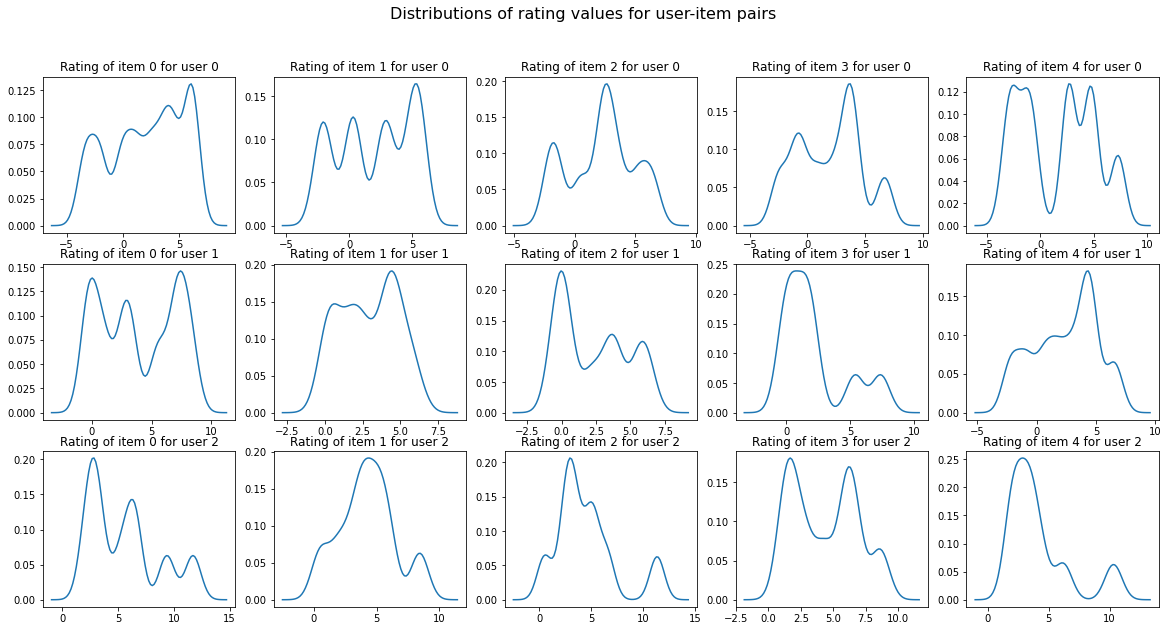

<IPython.core.display.Javascript object>

In [39]:
plot_bayesian_pmf_distributions(
    means=(
        bpmf_model := bpmf_models["bpmf"].model.model
    ).step_explicit_normal_distribution_means[:, :3, :5],
    precision=bpmf_model.alpha,
)

In the current implementation of Bayesian PMF no penalty is associated with missing ratings, it is not assumed that items with missing ratings are less relevant, so predicted ratings are all close to 4 - overall rating mean.

In [40]:
from implicit.gpu.als import AlternatingLeastSquares


class ALSFiltered(SparseRecommender):
    def __init__(self, *args, filtered_train_reviews, **kwargs):
        super().__init__(*args, **kwargs)
        self.filtered_train_reviews = filtered_train_reviews

    def fit(self, reviews):
        super().fit(self.filtered_train_reviews)

<IPython.core.display.Javascript object>

In [41]:
als_models = {
    "als": SparseRecommender(sparse_interface, AlternatingLeastSquares()),
    "als_filtered": ALSFiltered(
        sparse_interface,
        AlternatingLeastSquares(),
        filtered_train_reviews=train_reviews.query("rating >= 4").assign(rating=1),
    ),
}
assessor.assess(als_models)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [42]:
assessor.show_metrics("table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.032909,0.027927,0.133627,0.098266,0.021530,0.018505,1.000000,0.906977,0.814839,0.501585
popular,0.059019,0.073702,0.077827,0.089595,0.057450,0.071810,0.284672,0.395349,0.664661,0.654923
slim,0.090826,0.092960,0.140969,0.138728,0.081174,0.078261,0.751825,0.709302,0.425978,0.289910
bpmf,0.018275,0.014932,0.066079,0.054913,0.011902,0.009530,0.985401,0.988372,0.413791,0.224321
als,0.000000,0.028106,0.000000,0.086705,0.000000,0.020146,0.978102,0.813953,0.877083,0.432690
als_filtered,0.000000,0.031622,0.000000,0.092486,0.000000,0.021323,0.970803,0.802326,0.878657,0.429909


<IPython.core.display.Javascript object>

**(1.0 балла) Задание 8.**

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи. Используя фичи и не используя фичи, сравните результат.

In [781]:
from lightfm import LightFM


class LightRecommender(BatchRecommender):
    def __init__(self, *args, feature_importance=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.user_features, self.item_features = self.sparse_interface.scale_features(
            feature_importance
        )

    def fit(self, reviews):
        self.model.fit(
            interactions=self.sparse_interface.interactions,
            sample_weight=self.sparse_interface.interactions_weighted,
            user_features=self.user_features,
            item_features=self.item_features,
            epochs=10,
            num_threads=8,
            verbose=True,
        )
        return self

    def model_recommend(self, user_ids, interactions):
        user_ids, item_ids = np.meshgrid(
            user_ids, range(len(self.sparse_interface.organisations)), indexing="ij"
        )

        recommendations = self.model.predict(
            user_ids=user_ids.flatten(),
            item_ids=item_ids.flatten(),
            user_features=self.user_features,
            item_features=self.item_features,
            num_threads=8,
        ).reshape(user_ids.shape)

        return recommendations

ModuleNotFoundError: No module named 'lightfm'

<IPython.core.display.Javascript object>

In [ ]:
light_models = {
    f"light_feature_importance_{feature_importance}": LightRecommender(
        sparse_interface, LightFM(), feature_importance=feature_importance
    )
    for feature_importance in [0, 0.1, 0.25, 0.5]
}
assessor.assess(light_models)

In [61]:
assessor.show_metrics(kind="table")

,train_mnap,val_mnap,train_hitrate,val_hitrate,train_mrr,val_mrr,train_coverage,val_coverage,train_surprisal,val_surprisal
random,0.000112,0.000096,0.000923,0.000581,0.000166,0.000099,1.000000,0.914483,0.814951,0.569923
popular,0.005925,0.003523,0.018567,0.009424,0.010624,0.004419,0.000765,0.001007,0.437210,0.483808
tfidf,0.337795,0.015240,0.338338,0.104690,0.338043,0.013479,0.995293,0.905298,0.771607,0.498584
bm25,0.337348,0.018510,0.338074,0.136852,0.337907,0.017151,0.966919,0.886322,0.721491,0.731392
cosine,0.337586,0.014197,0.338161,0.096809,0.337926,0.012577,0.989917,0.900818,0.782828,0.499409
svd_10,0.113964,0.040916,0.268531,0.119701,0.182651,0.039528,0.006964,0.008909,0.429239,0.479104
svd_21,0.142999,0.036116,0.286065,0.114706,0.230475,0.033937,0.007711,0.009840,0.445441,0.492667
svd_46,0.189464,0.026909,0.343070,0.089676,0.294988,0.024833,0.012532,0.016107,0.494780,0.539978
svd_100,0.241049,0.024224,0.411734,0.079867,0.362558,0.022466,0.020128,0.026173,0.525889,0.571336
svd_215,0.320770,0.022805,0.512215,0.075043,0.453813,0.020870,0.037405,0.048672,0.557657,0.603278


<IPython.core.display.Javascript object>

Light with features scores terribly because it recommends based on features and ratings, while the metrics are only based on known ratings. So it should be better at recommending new items for users, but requires different metrics to evaluate.

---

**(1.0 балла) Задание 9.**

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформулируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным признаковым описанием будет, например, факт рекомендации данной организации или скор/ранг от моделей SVD, ALS, LightFM.
   Примените catboost/xgboost/lightgbm для создания переранжирования рекомендаций. То есть сделаем двухуровневую модель. Выясните наиболее важные признаки моделей первого уровня.

In [138]:
from catboost import Pool, CatBoostRanker


@njit
def jit_user_ranks(user_id, recommended_org_ids, relevance, k):
    """
    :param user_id: id of user to generate ranks for
    :param recommended_org_ids: array of org_ids
    of shape(n_orgs,) that were recommended by some model
    """
    unique_org_ids = np.unique(recommended_org_ids)
    org_id_map = dict()
    for i, org_id in enumerate(unique_org_ids):
        org_id_map[org_id] = i

    rankings = np.full((len(unique_org_ids), len(recommended_org_ids) // k + 3), -1)
    rankings[:, 0] = user_id
    rankings[:, 1] = unique_org_ids

    for i, (org_id, rel) in enumerate(zip(recommended_org_ids, relevance)):
        row_id = org_id_map[org_id]
        rankings[row_id, 2] = rel
        rankings[row_id, i // k + 3] = i % k
    return rankings


@njit
def jit_rankings_per_user(user_ids, recommendations, relevance, k=20):
    rankings = []
    for user_id, rec, rel in zip(user_ids, recommendations, relevance):
        rankings.append(jit_user_ranks(user_id, rec, rel, k))

    return rankings


def recommendations_data_to_ranking(assessor, model_names):
    ranking_data = {}
    for dataset, metric in zip(
        ["train", "val"], [assessor.train_metrics, assessor.val_metrics]
    ):
        recommendations = []
        relevance = []

        for model_name in model_names:
            recommendation = assessor.assessments[model_name][
                f"{dataset}_recommendations"
            ]
            recommendations.append(recommendation)
            relevance.append(
                metric.binary_relevance(
                    relevant_pairs=metric.relevant_pairs.values,
                    recommendee_user_ids=recommendation.index.to_numpy(),
                    recommended_org_ids=recommendation.values,
                )
            )

        recommendations = pd.concat(recommendations, axis="columns")
        relevance = np.hstack(relevance)
        rankings = jit_rankings_per_user(
            recommendations.index.to_numpy(), recommendations.values, relevance
        )
        rankings = np.vstack(rankings)
        rankings = pd.DataFrame(
            rankings, columns=["user_id", "org_id", "relevance"] + model_names
        )
        ranking_data[dataset] = {
            "pool": Pool(
                data=rankings.drop(["user_id", "org_id", "relevance"], axis="columns"),
                cat_features=model_names,
                label=rankings["relevance"].values,
                group_id=rankings["user_id"].values,
            ),
            "relevance": rankings[["user_id", "org_id", "relevance"]],
        }

    return ranking_data

<IPython.core.display.Javascript object>

In [300]:
ranking_data = recommendations_data_to_ranking(
    assessor,
    model_names=[
        "bm25",
        "tfidf",
        "svd_10",
        "als_filtered",
        "light_feature_importance_0",
    ],
)

<IPython.core.display.Javascript object>

In [369]:
def assess_cb(assessor, ranking_data):
    cb_ranker = CatBoostRanker(task_type="GPU", devices="1:2",train_dir ="local")
    cb_ranker.fit(ranking_data["train"]["pool"], verbose=False)
    cb_relevance = cb_ranker.predict(ranking_data["val"]["pool"])

    cb_recommendations = pd.concat(
        [
            ranking_data["val"]["relevance"],
            pd.Series(cb_relevance, name="cb_relevance"),
        ],
        axis="columns",
    )
    cb_recommendations = cb_recommendations.groupby("user_id").apply(
        lambda df: df.sort_values("cb_relevance", ascending=False)["org_id"]
        .iloc[:20]
        .values
    )
    cb_recommendations = pd.DataFrame(
        np.stack(cb_recommendations.values), cb_recommendations.index
    )
    cb_val_metrics = assessor.val_metrics.calculate_metrics(cb_recommendations).rename(
        "catboost"
    )
    metrics = pd.concat(
        [i["val_metrics"] for i in assessor.assessments.values()] + [cb_val_metrics],
        axis="columns",
    )
    return cb_ranker, metrics

<IPython.core.display.Javascript object>

In [ ]:
cb_ranker, metrics = assess_cb(assessor, ranking_data)

In [349]:
metrics.T.style.background_gradient(cmap="coolwarm", low=0.5, high=0.5)

,mnap,hitrate,mrr,coverage,surprisal
random,0.000096,0.000581,0.000099,0.914483,0.569923
popular,0.003523,0.009424,0.004419,0.001007,0.483808
tfidf,0.015240,0.104690,0.013479,0.905298,0.498584
bm25,0.018510,0.136852,0.017151,0.886322,0.731392
cosine,0.014197,0.096809,0.012577,0.900818,0.499409
svd_10,0.040916,0.119701,0.039528,0.008909,0.479104
svd_21,0.036116,0.114706,0.033937,0.009840,0.492667
svd_46,0.026909,0.089676,0.024833,0.016107,0.539978
svd_100,0.024224,0.079867,0.022466,0.026173,0.571336
svd_215,0.022805,0.075043,0.020870,0.048672,0.603278


<IPython.core.display.Javascript object>

In [368]:
def calculate_feature_importance(cb_ranker, ranking_data):
    importance = cb_ranker.get_feature_importance(ranking_data["val"]["pool"])
    importance = pd.Series(importance, cb_ranker.feature_names_).rename(
        "cb feature importance"
    )
    importance = importance.to_frame().style.background_gradient(
        cmap="coolwarm", low=0.5, high=0.5
    )
    return importance

<IPython.core.display.Javascript object>

In [365]:
calculate_feature_importance(cb_ranker, ranking_data)

,cb feature importance
bm25,-0.027877
tfidf,-0.036065
svd_10,0.078488
als_filtered,0.002610
light_feature_importance_0,0.019997


<IPython.core.display.Javascript object>